In [31]:
# Imports
import pandas as pd
import numpy as np
import psycopg2
import time
from time import gmtime, strftime

In [2]:
# Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.font_manager
import seaborn as sns

%matplotlib inline

In [3]:
plt.style.use('ggplot')

plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#505050'
plt.rcParams['axes.labelcolor']= '#505050'
plt.rcParams['xtick.color'] = '#505050'
plt.rcParams['ytick.color'] = '#505050'
plt.rcParams['font.size']= 11

In [4]:
def countplot_frequency(df, column_name, title, order=None):
    ax = sns.countplot(x=column_name, data=df, order=order)
    plt.title(title)

    # Make twin axis
    ax2 = ax.twinx()

    # Switch so count axis is on right, frequency on left
    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

    # Also switch the labels over
    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')

    ax2.set_ylabel('Frequency [%]')

    ncount = len(df)
    for p in ax.patches:
        x = p.get_bbox().get_points()[:,0]
        y = p.get_bbox().get_points()[1,1]
        ax.annotate('{:.2f}%'.format(100.*y/ncount), (x.mean(), y), ha='center', va='bottom') # set the alignment of the text

    # Use a LinearLocator to ensure the correct number of ticks
    ax.yaxis.set_major_locator(mtick.LinearLocator(11))

    # Fix the frequency range to 0-100
    ax2.set_ylim(0, 100)
    ax.set_ylim(0, ncount)

    # And use a MultipleLocator to ensure a tick spacing of 10
    ax2.yaxis.set_major_locator(mtick.MultipleLocator(10))

    # Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
    ax2.grid(None)
    return ax, ax2

### POSTGRESQL

In [5]:
# Notebook
host = '/tmp'

# Locus
# host = '/var/run/postgresql'

con = psycopg2.connect(dbname ='mimic', user='postgres', password="*2465RMLbru", host=host)
cur = con.cursor()

### ICD-9 Codes table

In [6]:
diagnoses_query = '''SELECT * FROM mimiciii.diagnoses_icd;'''
mimic_diagnoses_df = pd.read_sql_query(diagnoses_query, con)

### ICD-9 Descriptions table

In [7]:
diagnoses_descriptions_query = '''SELECT * FROM mimiciii.d_icd_diagnoses;'''
mimic_diagnoses_descriptions_df = pd.read_sql_query(diagnoses_descriptions_query, con)

### ICU Stays (patients details)

link:
https://github.com/MIT-LCP/mimic-code/blob/master/tutorials/cohort-selection.ipynb

"As MIMIC-III is primarily an intensive care unit (ICU) database, the focus will be on patients admitted to and discharged from the ICU. That is, rather than selecting our cohort based off the individual patient (identified by subject_id in the database), we will usually want to select our cohort based off the ICU stay (identified by icustay_id). Thus, it is sensible to begin with the icustays table."

In [8]:
icustay_query = 'SELECT * FROM mimiciii.icustay_detail_v2;' 
icustay_details_df = pd.read_sql_query(icustay_query, con)

In [9]:
def normalize_insurance(ins):
    if ins in ['Government', 'Medicaid', 'Medicare']:
        return 'Public'
    elif ins == 'Private':
        return 'Private'
    else:
        return 'Self-Pay'
    
# We are not considering MULTI RACE ETHNICITY, NATIVE, UNKNOWN or OTHER 
icustay_details_df = icustay_details_df[(icustay_details_df['ethnicity_grouped'] != 'other') & (icustay_details_df['ethnicity_grouped'] != 'unknown') & (icustay_details_df['ethnicity_grouped'] != 'native')]

# +18 years old (300 years old are patients older than 89)
icustay_details_df = icustay_details_df[(icustay_details_df['age'] >= 18) & (icustay_details_df['age'] < 300)]

# insurance
icustay_details_df['insurance'] = icustay_details_df['insurance'].apply(normalize_insurance)

# icd9 merge
icu_diagnoses_df = pd.merge(icustay_details_df, mimic_diagnoses_df, on = ['subject_id', 'hadm_id'], how = 'inner')

In [10]:
eth_mortality_df = icu_diagnoses_df.groupby(['icd9_code', 'ethnicity_grouped', 'hospital_expire_flag']).size().unstack()
eth_mortality_df = eth_mortality_df.reset_index()
eth_mortality_df.columns.names = [None]
eth_mortality_df.columns = ['icd9_code', 'ethnicity', 'alive', 'dead']
eth_mortality_df.insert(4, 'total', '0')
eth_mortality_df = eth_mortality_df.fillna(0)
eth_mortality_df['total'] = eth_mortality_df['total'].astype(float)

# Compute alive, dead and total
for index, row in eth_mortality_df.iterrows():
    eth_mortality_df.at[index, 'total'] = row['alive'] + row['dead']

In [11]:
# merge mortality with descriptions from each ICD
eth_mortality_df = eth_mortality_df.merge(mimic_diagnoses_descriptions_df, left_on='icd9_code', right_on='icd9_code')

#### Transplanted patients

In [12]:
# Search only for patients with transplant description
transplanted_patients_df = eth_mortality_df[eth_mortality_df['long_title'].str.lower().str.contains('transplant')].copy()

# 1. Mortality significance: only +1 patients dead
transplanted_patients_df = transplanted_patients_df.loc[eth_mortality_df['dead'] > 1]

# 2. Remove ICD9 codes with only ONE ETHNICITY
for index, row in transplanted_patients_df.iterrows():
    rows = transplanted_patients_df.loc[transplanted_patients_df['icd9_code'] == row['icd9_code']]
    if (len(rows) == 1):
        transplanted_patients_df.drop(rows.index, inplace=True)
        
transplanted_patients_df = transplanted_patients_df.drop(['row_id', 'short_title'], axis=1)

#### Cancer

In [13]:
searchfor = ['neoplasm', 'neoplasms', 'sarcoma', 'carcinoma']
cancer_patients_df = eth_mortality_df[eth_mortality_df['long_title'].str.lower().str.contains('|'.join(searchfor))].copy()

# 1. Mortality significance: only +1 patients dead
cancer_patients_df = cancer_patients_df.loc[cancer_patients_df['dead'] > 1]

# 2. Remove ICD9 codes with only ONE ETHNICITY
for index, row in cancer_patients_df.iterrows():
    rows = cancer_patients_df.loc[cancer_patients_df['icd9_code'] == row['icd9_code']]
    if (len(rows) == 1):
        cancer_patients_df.drop(rows.index, inplace=True)
        
cancer_patients_df = cancer_patients_df.drop(['row_id', 'short_title'], axis=1)


#### Diabetes

In [14]:
diabetes_patients_df = eth_mortality_df[eth_mortality_df['long_title'].str.lower().str.contains('diabetes')].copy()

# 1. Mortality significance: only +1 patients dead
diabetes_patients_df = diabetes_patients_df.loc[diabetes_patients_df['dead'] > 1]

# 2. Remove ICD9 codes with only ONE ETHNICITY
for index, row in diabetes_patients_df.iterrows():
    rows = diabetes_patients_df.loc[diabetes_patients_df['icd9_code'] == row['icd9_code']]
    if (len(rows) == 1):
        diabetes_patients_df.drop(rows.index, inplace=True)
        
diabetes_patients_df = diabetes_patients_df.drop(['row_id', 'short_title'], axis=1)

#### Select admissions

In [15]:
icd9_list = set(transplanted_patients_df['icd9_code'])
icd9_list.update(cancer_patients_df['icd9_code'])
icd9_list.update(diabetes_patients_df['icd9_code'])

hadm_ids_list = set()

for icd9 in icd9_list:    
    patients = icu_diagnoses_df.loc[(icu_diagnoses_df["icd9_code"] == icd9)].copy()
    for hadm_id in patients['hadm_id']:
        hadm_ids_list.add(hadm_id)

### Oasis score

Oxford Acute Severity of Illness Score (OASIS)
- This score is a measure of severity of illness for patients in the ICU.
- The score is calculated on the first day of each ICU patients' stay.

Variables used in OASIS:
-  Heart rate, GCS, MAP, Temperature, Respiratory rate, Ventilation status (sourced from CHARTEVENTS)
-  Urine output (sourced from OUTPUTEVENTS)
-  Elective surgery (sourced from ADMISSIONS and SERVICES)
-  Pre-ICU in-hospital length of stay (sourced from ADMISSIONS and ICUSTAYS)
-  Age (sourced from PATIENTS)

In [16]:
# Get the OASIS scores (ONLY IF PATIENT WAS ADMITTED TO THE ICU(intensive care unit))
oasis_query = 'SELECT distinct hadm_id, max(oasis) as oasis FROM mimiciii.oasis GROUP BY hadm_id'
oasis_df = pd.read_sql_query(oasis_query, con)

In [37]:
# Scores
# Low: 0-32
# Medium: 33-40
# High: 41+
def select(scores):
    low, medium, high = [], [], []
    for hadm_id in hadm_ids_list:
        if scores[hadm_id] < 33:
            low.append(hadm_id)
        elif scores[hadm_id] < 41:
            medium.append(hadm_id)
        else:
            high.append(hadm_id)
    return low, medium, high

oasis_scores = dict(oasis_df[['hadm_id','oasis']].values)
pat_oasis_score_low, pat_oasis_score_medium, pat_oasis_score_high = select(oasis_scores)

In [38]:
print(len(pat_oasis_score_low), len(pat_oasis_score_medium), len(pat_oasis_score_high))

9737 4613 2807


### Cohort

In [32]:
print(time.strftime("%Y-%m-%d %H:%M:%s"))

cohort_low_df = pd.DataFrame()
cohort_medium_df = pd.DataFrame()
cohort_high_df = pd.DataFrame()

for hid in pat_oasis_score_low:
    patients = icu_diagnoses_df.loc[(icu_diagnoses_df["hadm_id"] == hid)].copy()
    cohort_low_df = cohort_low_df.append(patients, ignore_index=True)
    
for hid in pat_oasis_score_medium:
    patients = icu_diagnoses_df.loc[(icu_diagnoses_df["hadm_id"] == hid)].copy()
    cohort_medium_df = cohort_medium_df.append(patients, ignore_index=True)
    
for hid in pat_oasis_score_high:
    patients = icu_diagnoses_df.loc[(icu_diagnoses_df["hadm_id"] == hid)].copy()
    cohort_high_df = cohort_high_df.append(patients, ignore_index=True)

print(time.strftime("%Y-%m-%d %H:%M:%s"))

2019-11-20 18:57:1574287051
2019-11-20 19:03:1574287405


In [34]:
# REMOVE: same admission multiple times for different ICD9
cohort_low_df.drop_duplicates(subset='hadm_id', keep='last', inplace=True)
cohort_medium_df.drop_duplicates(subset='hadm_id', keep='last', inplace=True)
cohort_high_df.drop_duplicates(subset='hadm_id', keep='last', inplace=True)

### MIMIC III Population characteristics

In [35]:
# Pollard TJ, Johnson AEW, Raffa JD, Mark RG (2018). tableone: An open source
# Python package for producing summary statistics for research papers.
# JAMIA Open, Volume 1, Issue 1, 1 July 2018, Pages 26-31.
# https://doi.org/10.1093/jamiaopen/ooy012
    
# Table One
from tableone import TableOne

# optionally, a categorical variable for stratification
groupby = ['ethnicity_grouped']

# columns to be summarized
columns = ['gender', 'insurance','los_hospital', 'age'] 

# columns containing categorical variables
categorical = ['gender', 'insurance']

# non-normal variables
nonnormal = ['age', 'los_hospital']

# alternative labels
labels={'los_hospital': 'Length of Stay', 'age': 'Age', 'ethnicity_grouped':'Ethnicity',
        'gender':'Gender', 'insurance':'Insurance'}

# combine all information
grouped_medium_df = cohort_medium_df
grouped_high_df = cohort_high_df

# create an instance of TableOne with the input arguments
grouped_medium_table = TableOne(grouped_medium_df, columns, categorical, groupby, nonnormal, rename=labels, isnull=False)
grouped_high_table = TableOne(grouped_high_df, columns, categorical, groupby, nonnormal, rename=labels, isnull=False)

# view tableone
grouped_medium_table

Grouped by Ethnicity                                                      
                                       asian             black          hispanic             white
variable       level                                                                              
n                                        145               593               188              3687
Gender         F                   54 (37.2)        339 (57.2)         79 (42.0)       1606 (43.6)
               M                   91 (62.8)        254 (42.8)        109 (58.0)       2081 (56.4)
Insurance      Private             28 (19.3)        109 (18.4)         35 (18.6)        891 (24.2)
               Public             117 (80.7)        481 (81.1)        153 (81.4)       2791 (75.7)
               Self-Pay                                3 (0.5)                             5 (0.1)
Length of Stay                9.6 [4.9,15.8]    7.6 [4.3,12.1]    8.6 [4.9,13.8]    8.5 [5.3,14.3]
Age                         69.3 [59.0,78.5]  65.2 [57.1,74.0]  62.3 [51.1,71.0]  71.0 [61.1,79.6]
[1] Warning, Tukey test indicates far outliers in: los_hospital.
[2] Warning, test for normality reports non-normal distributions for: age, los_hospital.

In [36]:
# view tableone
grouped_high_table

Grouped by Ethnicity                                                      
                                       asian             black          hispanic             white
variable       level                                                                              
n                                         81               403                97              2226
Gender         F                   31 (38.3)        250 (62.0)         39 (40.2)       1001 (45.0)
               M                   50 (61.7)        153 (38.0)         58 (59.8)       1225 (55.0)
Insurance      Private             13 (16.0)         64 (15.9)         16 (16.5)        468 (21.0)
               Public              68 (84.0)        338 (83.9)         79 (81.4)       1749 (78.6)
               Self-Pay                                1 (0.2)           2 (2.1)           9 (0.4)
Length of Stay                7.7 [3.0,15.9]    9.6 [5.1,18.0]    9.9 [4.6,19.5]    9.1 [4.9,16.7]
Age                         77.0 [66.1,81.1]  69.7 [60.2,78.5]  65.0 [54.9,78.3]  74.3 [63.3,81.8]
[1] Warning, Hartigan's Dip Test reports possible multimodal distributions for: los_hospital.
[2] Warning, Tukey test indicates far outliers in: los_hospital.
[3] Warning, test for normality reports non-normal distributions for: age, los_hospital.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a261fab38>,
      dtype=object)

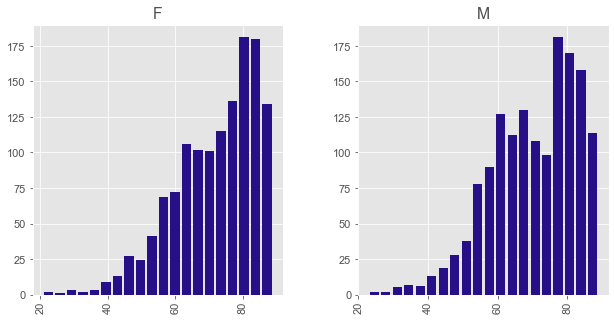

In [39]:
# Total (by gender)
cohort_high_df.hist(column='age', by='gender', bins=20, color='#271087', zorder=2, rwidth=0.8, figsize=(10, 5))

# cohort_medium_df.hist(column='age', by='gender', bins=20, color='#271087', zorder=2, rwidth=0.8, figsize=(10, 5))

(<matplotlib.axes._subplots.AxesSubplot at 0x1a24b11a58>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a23fa8e48>)

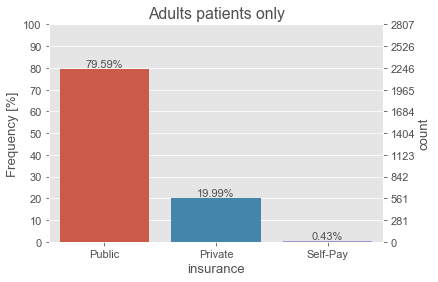

In [40]:
# Total (by insurance)
countplot_frequency(cohort_high_df, 'insurance', 'Adults patients only')

# countplot_frequency(cohort_medium_df, 'insurance', 'Adults patients only')

Text(0, 0.5, 'Density')

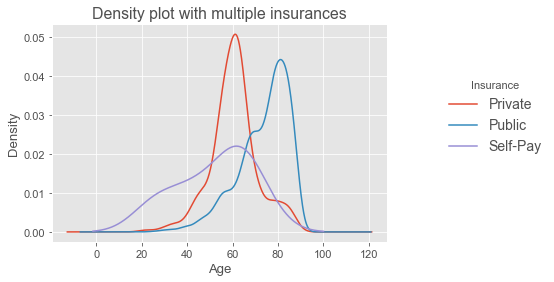

In [41]:
# Insurance by age
cohort_high_df.groupby('insurance')['age'].plot(kind='density')

# cohort_medium_df.groupby('insurance')['age'].plot(kind='density')

plt.legend(prop={'size': 14}, title = 'Insurance', frameon=False, bbox_to_anchor=(1.5, 0.8))
plt.title('Density plot with multiple insurances')
plt.xlabel('Age')
plt.ylabel('Density')

Text(0, 0.5, '# patients')

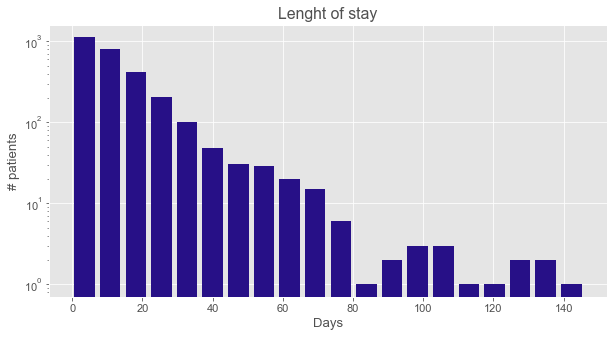

In [42]:
# Lenght of stay
cohort_high_df.hist(column='los_hospital', bins=20, color='#271087', grid=True, zorder=2, rwidth=0.8, figsize=(10, 5))

# cohort_medium_df.hist(column='los_hospital', bins=20, color='#271087', grid=True, zorder=2, rwidth=0.8, figsize=(10, 5))

plt.yscale('log')
plt.title('Lenght of stay')
plt.xlabel('Days')
plt.ylabel('# patients')

### Cox Regression

"Survival Analysis is used to estimate the lifespan of a particular population under study. It is also called ‘Time to Event’ Analysis as the goal is to estimate the time for an individual or a group of individuals to experience an event of interest. This time estimate is the duration between birth and death events. Survival Analysis was originally developed and used by Medical Researchers and Data Analysts to measure the lifetimes of a certain population."

In [43]:
cohort_high_df.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'gender', 'dod', 'admittime',
       'dischtime', 'insurance', 'los_hospital', 'age', 'ethnicity',
       'ethnicity_grouped', 'admission_type', 'hospital_expire_flag',
       'hospstay_seq', 'first_hosp_stay', 'intime', 'outtime', 'los_icu',
       'icustay_seq', 'first_icu_stay', 'row_id', 'seq_num', 'icd9_code'],
      dtype='object')

In [ ]:
from lifelines import CoxPHFitter

# event status: hospital_expire_flag (died in hospital or not)
# duration: los_icu (ICU lenght of stay in days)

cph = CoxPHFitter()
cph.fit(cohort_high_df, duration_col='los_icu', event_col='hospital_expire_flag')

# access the results using cph.summary
cph.print_summary()